In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import regex as re
import random
import math
import os
from tqdm.notebook import tqdm
import pyreadstat

In [10]:
x_train = pickle.load(open('data/train_x_raw.sav','rb'))
x_train

array(['Triển lãm MEVS - triển lãm dành riêng cho xe điện sẽ diễn ra tại Sân vận động Olympic Montreal từ ngày 21-23/4/2023 với sự xuất hiện của hơn 50 mẫu xe điện đến từ hơn 20 thương hiệu ô tô trên thế giới.Lần đầu tham dự MEVS 2023, VinFast sẽ giới thiệu 2 mẫu xe điện chủ lực của năm nay là VF 8 và VF 9. Khách tham quan có thể tìm hiểu thông tin sản phẩm và chính sách bán hàng của VinFast.Bà Nguyễn Thị Vân Anh, Tổng Giám đốc VinFast Bắc Mỹ chia sẻ: “Là một thương hiệu thuần điện, với mục tiêu thúc đẩy cuộc cách mạng xe điện toàn cầu, VinFast tự hào góp mặt tại triển lãm xe điện lớn nhất Canada ngay sau Triển lãm Ô tô Quốc tế Montreal hồi tháng 1. VinFast cũng đã ra mắt người tiêu dùng Canada thông qua cửa hàng VinFast Store mở tại Laval. Và giờ đây, chúng tôi rất hào hứng được mang đến cơ hội được lái thử chiếc xe VF 8 lần đầu tiên cho khách hàng Quebec.”VF 8 hiện là mẫu xe chủ đạo của VinFast tại các thị trường quốc tế. VF 8 bản Eco có giá từ $57.500 CAD và VF 8 Plus có giá từ $63.

In [11]:
x_train2 = pd.read_spss('data/train_x_raw.sav')

ReadstatError: Invalid file, or file has unsupported features

In [3]:
def sentence_len(text):
    return len(text.split(" "))
sizes = []
for content in x_train:
    sizes.append(sentence_len(content))
print("Do dai trung binh cua tap du lieu truoc tien xu li: ", np.mean(sizes))

Do dai trung binh cua tap du lieu truoc tien xu li:  530.2749509891285


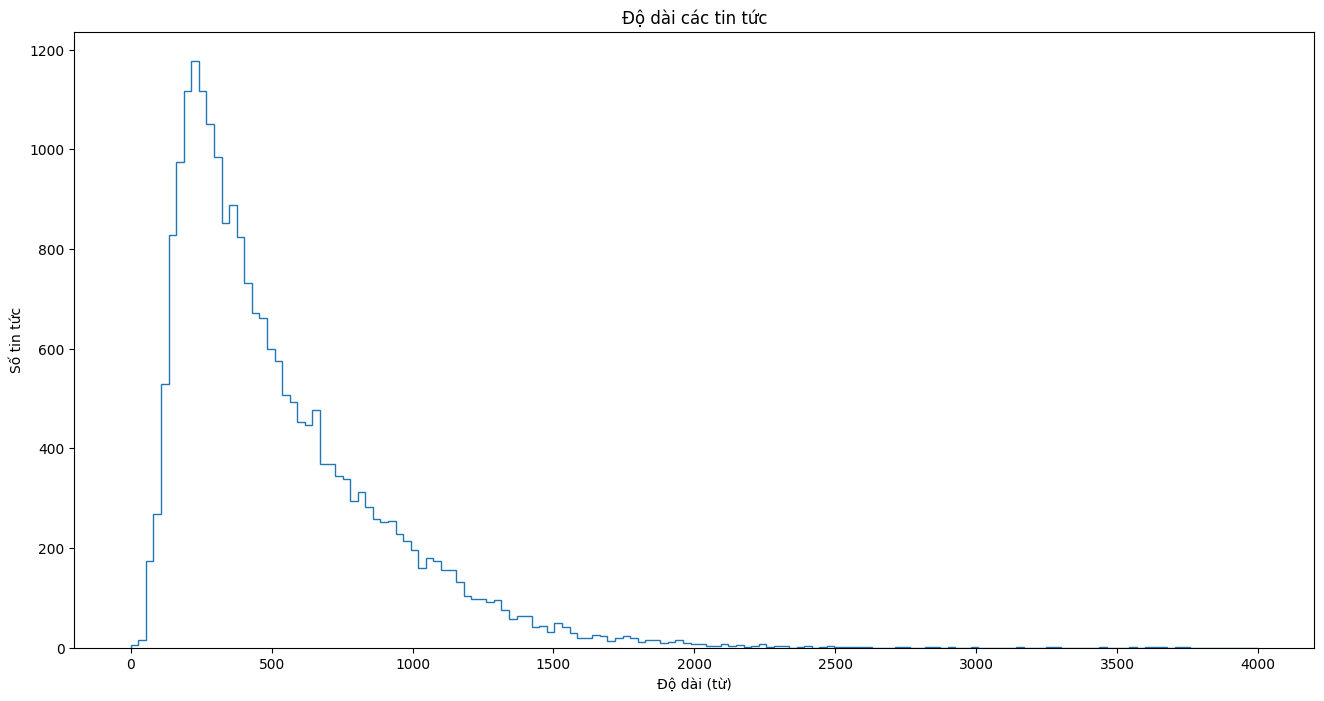

In [4]:
plt.figure(figsize=(16,8))
plt.title("Độ dài các tin tức")
plt.xlabel("Độ dài (từ)")
plt.ylabel("Số tin tức")
plt.hist(np.array(sizes), bins=int(math.sqrt(len(sizes))), histtype='step', range=(0, 4000))
plt.savefig('image/dataset_before_preprocess.png', facecolor='whitesmoke', bbox_inches='tight')
plt.show()

In [5]:
labels = np.unique(y_train)

In [6]:
labels

array(['Am nhac', 'Am thuc', 'Bat dong san', 'Bong da', 'Chung khoan',
       'Cum ga', 'Cuoc song do day', 'Du hoc', 'Du lich', 'Duong vao WTO',
       'Gia dinh', 'Giai tri tin hoc', 'Giao duc', 'Gioi tinh',
       'Hackers va Virus', 'Hinh su', 'Khong gian song',
       'Kinh doanh quoc te', 'Kinh te', 'Lam dep', 'Loi song', 'Mua sam',
       'My thuat', 'San khau dien anh', 'San pham tin hoc moi',
       'Suc khoe', 'Tennis', 'The gioi tre', 'Thoi trang', 'Xe co'],
      dtype=object)

In [7]:
label_len = {}
for label in labels:
    label_len[label] = np.count_nonzero(y_train == label)
label_len

{'Am nhac': 1296,
 'Am thuc': 528,
 'Bat dong san': 458,
 'Bong da': 2567,
 'Chung khoan': 513,
 'Cum ga': 661,
 'Cuoc song do day': 1174,
 'Du hoc': 765,
 'Du lich': 1102,
 'Duong vao WTO': 289,
 'Gia dinh': 375,
 'Giai tri tin hoc': 1328,
 'Giao duc': 1348,
 'Gioi tinh': 446,
 'Hackers va Virus': 489,
 'Hinh su': 395,
 'Khong gian song': 150,
 'Kinh doanh quoc te': 985,
 'Kinh te': 540,
 'Lam dep': 1077,
 'Loi song': 425,
 'Mua sam': 206,
 'My thuat': 259,
 'San khau dien anh': 1667,
 'San pham tin hoc moi': 1093,
 'Suc khoe': 165,
 'Tennis': 630,
 'The gioi tre': 759,
 'Thoi trang': 542,
 'Xe co': 212}

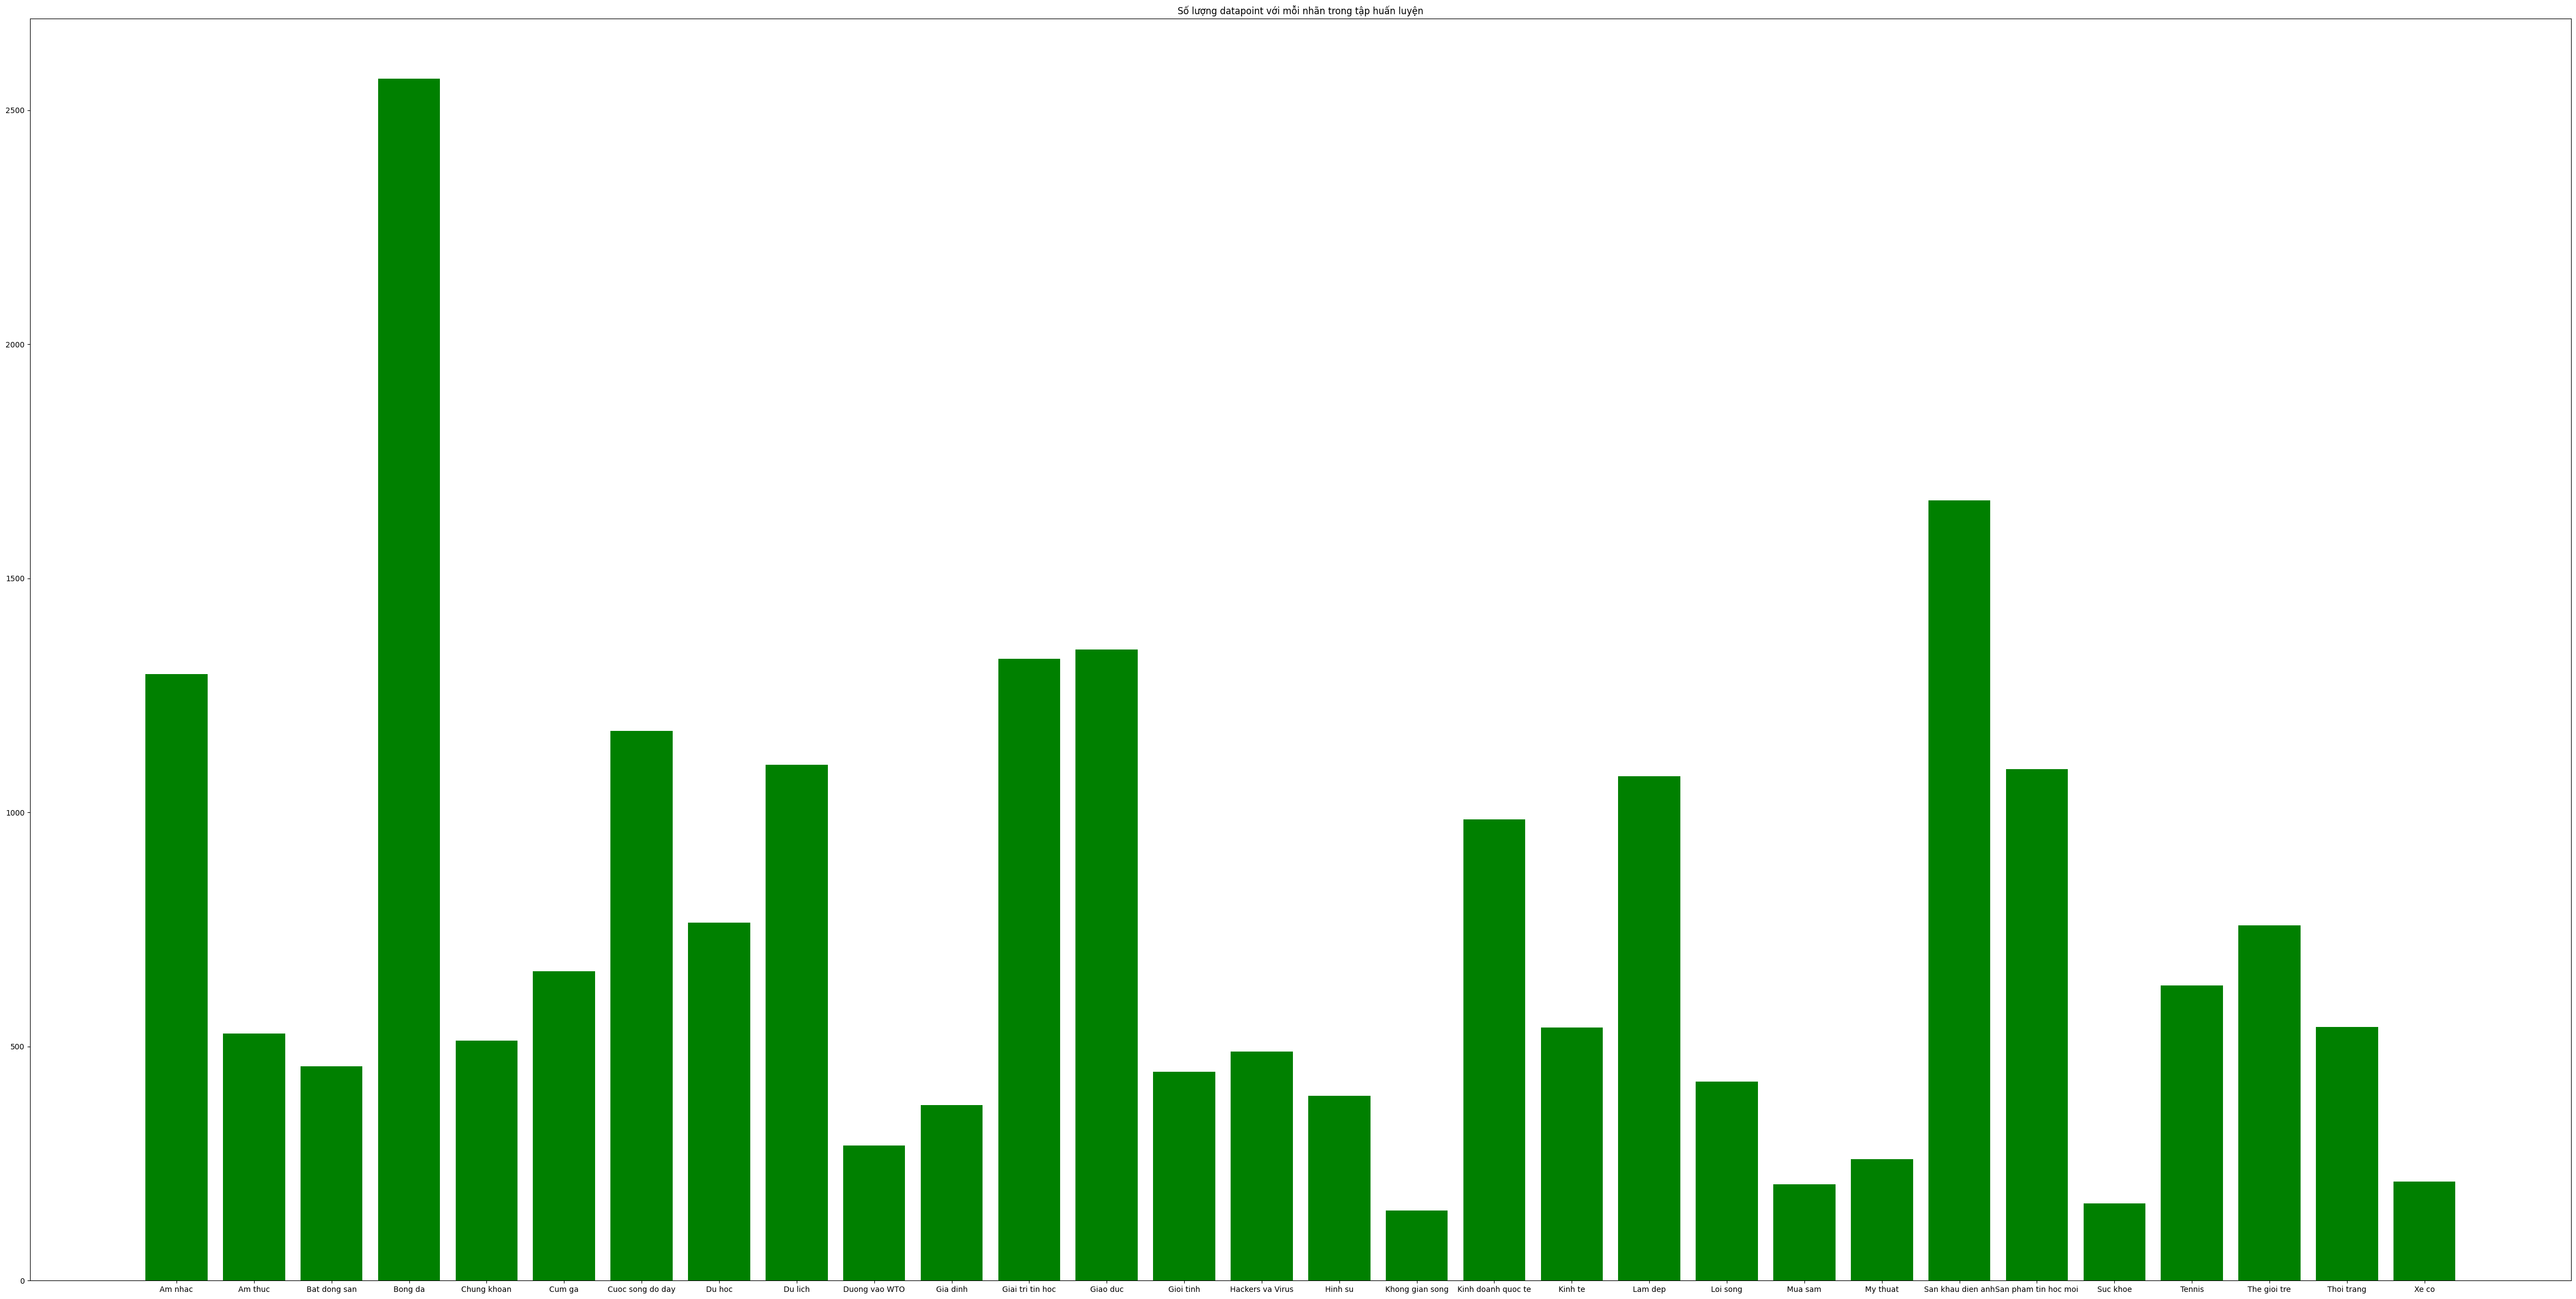

In [8]:
plt.figure(figsize=(60,30))
plt.title('Số lượng datapoint với mỗi nhãn trong tập huấn luyện')
plt.bar(list(label_len.keys()), label_len.values(), color='g')
plt.show()

## Tiền xử lý gồm những việc sau:
- Xoá HTML code
- Chuẩn hóa bảng mã Unicode
- Chuẩn hóa kiểu gõ dấu tiếng Việt (dùng òa úy thay cho oà uý)
- Đưa văn bản về dạng viết thường
- Thực hiện tách từ tiếng Việt
- Xóa các ký tự đặc biệt
- Loại bỏ stopwords

### 1. Xoa code HTML


In [9]:
# trong khi crawl du lieu co the du lai cac ki tu html
# xoa bo code html bang regex
import re
def remove_html(text):
    return re.sub(r'<[^>]*>', '', text)
txt = "<p class=\"par\">Đây là 1 ví dụ xoá html code</p>"
remove_html(txt)

'Đây là 1 ví dụ xoá html code'

### 2. Chuan hoa bang ma unicode
- Hien nay co 2 loai bang ma thuong dung do la Unicode dung san va Unicode to hop
- Unicode dung san kha pho bien nen ta se chuyen tu Unicode to hop ve Unicode dung san

In [10]:
def compound_unicode(unicode_str):
  """
  Chuyển đổi chuỗi Unicode Tổ Hợp sang Unicode Dựng Sẵn
  Edited from: `https://gist.github.com/redphx/9320735`
  """
  unicode_str = unicode_str.replace("\u0065\u0309", "\u1EBB")    # ẻ
  unicode_str = unicode_str.replace("\u0065\u0301", "\u00E9")    # é
  unicode_str = unicode_str.replace("\u0065\u0300", "\u00E8")    # è
  unicode_str = unicode_str.replace("\u0065\u0323", "\u1EB9")    # ẹ
  unicode_str = unicode_str.replace("\u0065\u0303", "\u1EBD")    # ẽ
  unicode_str = unicode_str.replace("\u00EA\u0309", "\u1EC3")    # ể
  unicode_str = unicode_str.replace("\u00EA\u0301", "\u1EBF")    # ế
  unicode_str = unicode_str.replace("\u00EA\u0300", "\u1EC1")    # ề
  unicode_str = unicode_str.replace("\u00EA\u0323", "\u1EC7")    # ệ
  unicode_str = unicode_str.replace("\u00EA\u0303", "\u1EC5")    # ễ
  unicode_str = unicode_str.replace("\u0079\u0309", "\u1EF7")    # ỷ
  unicode_str = unicode_str.replace("\u0079\u0301", "\u00FD")    # ý
  unicode_str = unicode_str.replace("\u0079\u0300", "\u1EF3")    # ỳ
  unicode_str = unicode_str.replace("\u0079\u0323", "\u1EF5")    # ỵ
  unicode_str = unicode_str.replace("\u0079\u0303", "\u1EF9")    # ỹ
  unicode_str = unicode_str.replace("\u0075\u0309", "\u1EE7")    # ủ
  unicode_str = unicode_str.replace("\u0075\u0301", "\u00FA")    # ú
  unicode_str = unicode_str.replace("\u0075\u0300", "\u00F9")    # ù
  unicode_str = unicode_str.replace("\u0075\u0323", "\u1EE5")    # ụ
  unicode_str = unicode_str.replace("\u0075\u0303", "\u0169")    # ũ
  unicode_str = unicode_str.replace("\u01B0\u0309", "\u1EED")    # ử
  unicode_str = unicode_str.replace("\u01B0\u0301", "\u1EE9")    # ứ
  unicode_str = unicode_str.replace("\u01B0\u0300", "\u1EEB")    # ừ
  unicode_str = unicode_str.replace("\u01B0\u0323", "\u1EF1")    # ự
  unicode_str = unicode_str.replace("\u01B0\u0303", "\u1EEF")    # ữ
  unicode_str = unicode_str.replace("\u0069\u0309", "\u1EC9")    # ỉ
  unicode_str = unicode_str.replace("\u0069\u0301", "\u00ED")    # í
  unicode_str = unicode_str.replace("\u0069\u0300", "\u00EC")    # ì
  unicode_str = unicode_str.replace("\u0069\u0323", "\u1ECB")    # ị
  unicode_str = unicode_str.replace("\u0069\u0303", "\u0129")    # ĩ
  unicode_str = unicode_str.replace("\u006F\u0309", "\u1ECF")    # ỏ
  unicode_str = unicode_str.replace("\u006F\u0301", "\u00F3")    # ó
  unicode_str = unicode_str.replace("\u006F\u0300", "\u00F2")    # ò
  unicode_str = unicode_str.replace("\u006F\u0323", "\u1ECD")    # ọ
  unicode_str = unicode_str.replace("\u006F\u0303", "\u00F5")    # õ
  unicode_str = unicode_str.replace("\u01A1\u0309", "\u1EDF")    # ở
  unicode_str = unicode_str.replace("\u01A1\u0301", "\u1EDB")    # ớ
  unicode_str = unicode_str.replace("\u01A1\u0300", "\u1EDD")    # ờ
  unicode_str = unicode_str.replace("\u01A1\u0323", "\u1EE3")    # ợ
  unicode_str = unicode_str.replace("\u01A1\u0303", "\u1EE1")    # ỡ
  unicode_str = unicode_str.replace("\u00F4\u0309", "\u1ED5")    # ổ
  unicode_str = unicode_str.replace("\u00F4\u0301", "\u1ED1")    # ố
  unicode_str = unicode_str.replace("\u00F4\u0300", "\u1ED3")    # ồ
  unicode_str = unicode_str.replace("\u00F4\u0323", "\u1ED9")    # ộ
  unicode_str = unicode_str.replace("\u00F4\u0303", "\u1ED7")    # ỗ
  unicode_str = unicode_str.replace("\u0061\u0309", "\u1EA3")    # ả
  unicode_str = unicode_str.replace("\u0061\u0301", "\u00E1")    # á
  unicode_str = unicode_str.replace("\u0061\u0300", "\u00E0")    # à
  unicode_str = unicode_str.replace("\u0061\u0323", "\u1EA1")    # ạ
  unicode_str = unicode_str.replace("\u0061\u0303", "\u00E3")    # ã
  unicode_str = unicode_str.replace("\u0103\u0309", "\u1EB3")    # ẳ
  unicode_str = unicode_str.replace("\u0103\u0301", "\u1EAF")    # ắ
  unicode_str = unicode_str.replace("\u0103\u0300", "\u1EB1")    # ằ
  unicode_str = unicode_str.replace("\u0103\u0323", "\u1EB7")    # ặ
  unicode_str = unicode_str.replace("\u0103\u0303", "\u1EB5")    # ẵ
  unicode_str = unicode_str.replace("\u00E2\u0309", "\u1EA9")    # ẩ
  unicode_str = unicode_str.replace("\u00E2\u0301", "\u1EA5")    # ấ
  unicode_str = unicode_str.replace("\u00E2\u0300", "\u1EA7")    # ầ
  unicode_str = unicode_str.replace("\u00E2\u0323", "\u1EAD")    # ậ
  unicode_str = unicode_str.replace("\u00E2\u0303", "\u1EAB")    # ẫ
  unicode_str = unicode_str.replace("\u0045\u0309", "\u1EBA")    # Ẻ
  unicode_str = unicode_str.replace("\u0045\u0301", "\u00C9")    # É
  unicode_str = unicode_str.replace("\u0045\u0300", "\u00C8")    # È
  unicode_str = unicode_str.replace("\u0045\u0323", "\u1EB8")    # Ẹ
  unicode_str = unicode_str.replace("\u0045\u0303", "\u1EBC")    # Ẽ
  unicode_str = unicode_str.replace("\u00CA\u0309", "\u1EC2")    # Ể
  unicode_str = unicode_str.replace("\u00CA\u0301", "\u1EBE")    # Ế
  unicode_str = unicode_str.replace("\u00CA\u0300", "\u1EC0")    # Ề
  unicode_str = unicode_str.replace("\u00CA\u0323", "\u1EC6")    # Ệ
  unicode_str = unicode_str.replace("\u00CA\u0303", "\u1EC4")    # Ễ
  unicode_str = unicode_str.replace("\u0059\u0309", "\u1EF6")    # Ỷ
  unicode_str = unicode_str.replace("\u0059\u0301", "\u00DD")    # Ý
  unicode_str = unicode_str.replace("\u0059\u0300", "\u1EF2")    # Ỳ
  unicode_str = unicode_str.replace("\u0059\u0323", "\u1EF4")    # Ỵ
  unicode_str = unicode_str.replace("\u0059\u0303", "\u1EF8")    # Ỹ
  unicode_str = unicode_str.replace("\u0055\u0309", "\u1EE6")    # Ủ
  unicode_str = unicode_str.replace("\u0055\u0301", "\u00DA")    # Ú
  unicode_str = unicode_str.replace("\u0055\u0300", "\u00D9")    # Ù
  unicode_str = unicode_str.replace("\u0055\u0323", "\u1EE4")    # Ụ
  unicode_str = unicode_str.replace("\u0055\u0303", "\u0168")    # Ũ
  unicode_str = unicode_str.replace("\u01AF\u0309", "\u1EEC")    # Ử
  unicode_str = unicode_str.replace("\u01AF\u0301", "\u1EE8")    # Ứ
  unicode_str = unicode_str.replace("\u01AF\u0300", "\u1EEA")    # Ừ
  unicode_str = unicode_str.replace("\u01AF\u0323", "\u1EF0")    # Ự
  unicode_str = unicode_str.replace("\u01AF\u0303", "\u1EEE")    # Ữ
  unicode_str = unicode_str.replace("\u0049\u0309", "\u1EC8")    # Ỉ
  unicode_str = unicode_str.replace("\u0049\u0301", "\u00CD")    # Í
  unicode_str = unicode_str.replace("\u0049\u0300", "\u00CC")    # Ì
  unicode_str = unicode_str.replace("\u0049\u0323", "\u1ECA")    # Ị
  unicode_str = unicode_str.replace("\u0049\u0303", "\u0128")    # Ĩ
  unicode_str = unicode_str.replace("\u004F\u0309", "\u1ECE")    # Ỏ
  unicode_str = unicode_str.replace("\u004F\u0301", "\u00D3")    # Ó
  unicode_str = unicode_str.replace("\u004F\u0300", "\u00D2")    # Ò
  unicode_str = unicode_str.replace("\u004F\u0323", "\u1ECC")    # Ọ
  unicode_str = unicode_str.replace("\u004F\u0303", "\u00D5")    # Õ
  unicode_str = unicode_str.replace("\u01A0\u0309", "\u1EDE")    # Ở
  unicode_str = unicode_str.replace("\u01A0\u0301", "\u1EDA")    # Ớ
  unicode_str = unicode_str.replace("\u01A0\u0300", "\u1EDC")    # Ờ
  unicode_str = unicode_str.replace("\u01A0\u0323", "\u1EE2")    # Ợ
  unicode_str = unicode_str.replace("\u01A0\u0303", "\u1EE0")    # Ỡ
  unicode_str = unicode_str.replace("\u00D4\u0309", "\u1ED4")    # Ổ
  unicode_str = unicode_str.replace("\u00D4\u0301", "\u1ED0")    # Ố
  unicode_str = unicode_str.replace("\u00D4\u0300", "\u1ED2")    # Ồ
  unicode_str = unicode_str.replace("\u00D4\u0323", "\u1ED8")    # Ộ
  unicode_str = unicode_str.replace("\u00D4\u0303", "\u1ED6")    # Ỗ
  unicode_str = unicode_str.replace("\u0041\u0309", "\u1EA2")    # Ả
  unicode_str = unicode_str.replace("\u0041\u0301", "\u00C1")    # Á
  unicode_str = unicode_str.replace("\u0041\u0300", "\u00C0")    # À
  unicode_str = unicode_str.replace("\u0041\u0323", "\u1EA0")    # Ạ
  unicode_str = unicode_str.replace("\u0041\u0303", "\u00C3")    # Ã
  unicode_str = unicode_str.replace("\u0102\u0309", "\u1EB2")    # Ẳ
  unicode_str = unicode_str.replace("\u0102\u0301", "\u1EAE")    # Ắ
  unicode_str = unicode_str.replace("\u0102\u0300", "\u1EB0")    # Ằ
  unicode_str = unicode_str.replace("\u0102\u0323", "\u1EB6")    # Ặ
  unicode_str = unicode_str.replace("\u0102\u0303", "\u1EB4")    # Ẵ
  unicode_str = unicode_str.replace("\u00C2\u0309", "\u1EA8")    # Ẩ
  unicode_str = unicode_str.replace("\u00C2\u0301", "\u1EA4")    # Ấ
  unicode_str = unicode_str.replace("\u00C2\u0300", "\u1EA6")    # Ầ
  unicode_str = unicode_str.replace("\u00C2\u0323", "\u1EAC")    # Ậ
  unicode_str = unicode_str.replace("\u00C2\u0303", "\u1EAA")    # Ẫ
  return unicode_str
#Thử nghiệm
type1 = 'hiếu' # Loại dựng sẵn
type2 = 'hiếu' # Loại tổ hợp

print(type1 == type2)
# Nếu là loại dựng sẵn thì không thay đổi
print(type1 == compound_unicode(type1))
# Nếu là loại tổ hợp thì sẽ đưa về loại dựng sẵn
print(type1 == compound_unicode(type2))

False
True
True


### 3. Chuan hoa kieu go Tieng Viet va dua ve chu viet thuong

In [11]:
bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)


In [12]:
def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            # for index2 in nguyen_am_index:
            #     if index2 != index:
            #         x, y = nguyen_am_to_ids[chars[index]]
            #         chars[index2] = bang_nguyen_am[x][0]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            # chars[nguyen_am_index[1]] = bang_nguyen_am[x][0]
        else:
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
        # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[2]]]
        # chars[nguyen_am_index[2]] = bang_nguyen_am[x][0]
    return ''.join(chars)


def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True


def chuan_hoa_dau_cau_tieng_viet(sentence):
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        words[index] = chuan_hoa_dau_tu_tieng_viet(word)
    return ' '.join(words)

### 4. Tach tu Tieng Viet

In [13]:
from pyvi import ViTokenizer

text = "Đây là một ví dụ minh họa về cách sử dụng VnTokenizer."
tokens = ViTokenizer.tokenize(text)
print(tokens)
test = ViTokenizer.tokenize(x_train[0])
print(test)

Đây là một ví_dụ minh_họa về cách sử_dụng VnTokenizer .
Triển_lãm MEVS - triển_lãm dành riêng cho xe điện sẽ diễn ra tại Sân vận_động Olympic_Montreal từ ngày 21 - 23 / 4 / 2023 với sự xuất_hiện của hơn 50 mẫu xe điện đến từ hơn 20 thương_hiệu ô_tô trên thế_giới . Lần đầu tham_dự MEVS 2023 , VinFast sẽ giới_thiệu 2 mẫu xe điện chủ_lực của năm nay là VF 8 và VF 9 . Khách tham_quan có_thể tìm_hiểu thông_tin sản_phẩm và chính_sách bán hàng của VinFast . Bà Nguyễn_Thị_Vân Anh , Tổng_Giám_đốc VinFast Bắc_Mỹ chia_sẻ : “ Là một thương_hiệu thuần điện , với mục_tiêu thúc_đẩy cuộc cách_mạng xe điện toàn_cầu , VinFast tự_hào góp_mặt tại triển_lãm xe điện lớn nhất Canada ngay sau Triển_lãm Ô_tô Quốc_tế Montreal hồi tháng 1 . VinFast cũng đã ra_mắt người tiêu_dùng Canada thông_qua cửa_hàng VinFast Store mở tại Laval . Và giờ_đây , chúng_tôi rất hào_hứng được mang đến cơ_hội được lái thử chiếc xe VF 8 lần đầu_tiên cho khách_hàng Quebec . ” VF 8 hiện là mẫu xe chủ_đạo của VinFast tại các thị_trường 

### 5. Xoa bo cac ki tu khong can thiet

Loại bỏ các ký tự không cần thiết giúp:
- Giảm số chiều đặc trưng, tăng tốc độc học và xử lý
- Tránh gây nhiễu, ảnh hưởng xấu tới kết quả mô hình

In [14]:
def remove_unnecessary_character(document):
    # Xoá các ký tự không cần thiết
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
    # Xoá khoảng trắng thừa
    document = re.sub(r'\s+', ' ', document).strip()
    return document

In [15]:
sentence = "19/4 Nếu bạn có bất kỳ câu hỏi hoặc cần thêm sự giúp đỡ nào khác, đừng ngần ngại để tôi biết!"
remove_unnecessary_character(sentence)

'19 4 Nếu bạn có bất kỳ câu hỏi hoặc cần thêm sự giúp đỡ nào khác đừng ngần ngại để tôi biết'

### 6. Hoan thanh cac buoc tren


In [16]:
from pyvi import ViTokenizer
def preprocess_data(vanban):
    # Xoa code HTML
    document = remove_html(vanban)

    #Chuan hoa bang ma unicode
    document = compound_unicode(document)

    #Chuan hoa kieu go tieng viet va dua ve chua viet thuong
    document = chuan_hoa_dau_cau_tieng_viet(document)

    #Tach tu tieng Viet
    document = ViTokenizer.tokenize(document)

    #Xoa bo cac ki tu khong can thiet
    document = remove_unnecessary_character(document)
    
    return document

### 7. Loai bo stopword

In [17]:
stopwords = pickle.load(open('data/saved/stopwords.sav', 'rb'))
stopwords

{'1',
 '2',
 '3',
 '4',
 '5',
 'anh',
 'biết',
 'bạn',
 'bằng',
 'bị',
 'bộ',
 'cao',
 'cho',
 'chưa',
 'chỉ',
 'các',
 'còn',
 'có',
 'có_thể',
 'cô',
 'cùng',
 'cũng',
 'cả',
 'cần',
 'của',
 'do',
 'hai',
 'hay',
 'hơn',
 'họ',
 'khi',
 'khác',
 'không',
 'là',
 'làm',
 'lên',
 'lại',
 'lần',
 'mà',
 'mình',
 'một',
 'mới',
 'nam',
 'ngày',
 'người',
 'nhiều',
 'nhà',
 'như',
 'nhưng',
 'nhất',
 'những',
 'này',
 'nên',
 'nói',
 'năm',
 'nước',
 'nếu',
 'phim',
 'phải',
 'qua',
 'ra',
 'rất',
 'rằng',
 'sau',
 'sẽ',
 'số',
 'sự',
 'theo',
 'tháng',
 'thì',
 'thứ',
 'trong',
 'trên',
 'trước',
 'trường',
 'tôi',
 'tại',
 'tới',
 'từ',
 'việc',
 'việt_nam',
 'và',
 'vào',
 'vì',
 'vẫn',
 'về',
 'với',
 'ông',
 'đang',
 'đi',
 'điều',
 'điểm',
 'đây',
 'đã',
 'đó',
 'được',
 'đến',
 'để',
 'đội',
 'ở'}

In [18]:
# Loại bỏ stopword
def remove_stopwords(document):
    words = document.split(' ')
    res = list()
    for word in words:
        if word not in stopwords:
            res.append(word)
    return ' '.join(res)

# Kiểm tra
remove_stopwords(preprocess_data('Theo nghị định đã ban hành, người dân cần ở trong nhà đến hết ngày 16/9.'))

'nghị_định ban_hành dân hết 16 9'

### Tien xu li tren tap train va test

In [19]:

for index,content in enumerate(tqdm(x_train)):
    x_train[index] = preprocess_data(content)

for index,content in enumerate(tqdm(x_test)):
    x_test[index] = preprocess_data(content)

  0%|          | 0/22444 [00:00<?, ?it/s]

  0%|          | 0/9620 [00:00<?, ?it/s]

In [20]:
stopwords_path = 'data/saved/stopwords.sav'
stopwords = pickle.load(open(stopwords_path, 'rb'))

In [21]:
for i, news in enumerate(tqdm(x_train)):
  x_train[i] = remove_stopwords(news)

print('Loại bỏ stopwords trên tập test...')
for i, news in enumerate(tqdm(x_test)):
  x_test[i] = remove_stopwords(news)

  0%|          | 0/22444 [00:00<?, ?it/s]

Loại bỏ stopwords trên tập test...


  0%|          | 0/9620 [00:00<?, ?it/s]

In [22]:
train_x_path = 'data/saved/train_x.sav'
train_y_path = 'data/saved/train_y.sav'
test_x_path = 'data/saved/test_x.sav'
test_y_path = 'data/saved/test_y.sav'

pickle.dump(x_train, open(train_x_path, 'wb'))
pickle.dump(y_train, open(train_y_path, 'wb'))
pickle.dump(x_test, open(test_x_path, 'wb'))
pickle.dump(y_test, open(test_y_path, 'wb'))

In [23]:
x_train = np.array(pickle.load(open('data/saved/train_x.sav', 'rb')))
y_train = np.array(pickle.load(open('data/saved/train_y.sav', 'rb')))
x_test = np.array(pickle.load(open('data/saved/test_x.sav', 'rb')))
y_test = np.array(pickle.load(open('data/saved/test_y.sav', 'rb')))

In [24]:
x_test

array(['trình_duyệt netscape hồi_sinh công_cụ duyệt web aol cuối_cùng chết giới phân_tích từng nhận_định năm_ngoái america online vừa công_bố gói phần_mềm nâng_cấp netscape internet một_số ứng_dụng desktop sắp_sửa tung chương_trình update nằm nỗ_lực quy_mô lớn aol nhằm thổi sức_sống thương_hiệu netscape mua 1998 giá tỷ usd phiên_bản nâng_cấp 7 thay_thế phần_mềm 7 tung giữa năm_ngoái browser dựa nền phiên_bản 7 trình_duyệt mozilla phần_mềm sắp tung ứng_dụng mozilla internet bản netscape 7 hiện_hành dựa mozilla trình_duyệt xuất_hiện đầu_tiên 6 2003 bản thử_nghiệm beta mozilla 7 phát_hành gói phần_mềm bao_gồm browser công_cụ e mail tiện_ích tập_tin newsgroup ứng_dụng nhắn_tin nhanh một_số tính_năng biên_tập trang_web chống pop up bên cạnh phần_mềm trình_duyệt aol lặng_lẽ phát_hành bản thử_nghiệm beta sản_phẩm tên netscape desktop navigator cung_cấp đường truy_nhập nội_dung web tính địa_phương dựa mã vùng sử_dụng thông_qua giao_diện tròn giống chiếc la_bàn hàng haỉ trung_tâm giao_diện công